#### Last Modified: Oct 10th 2021 (Opal). 

# Lagrangian OpInf on Solar Wind Radial Speed dataset


In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [3]:
from code.hux_propagation import *
from code.archimedes_sprial import compute_phi_shift_forward
from code.numerical_methods import apply_numerical_method

# Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr="2210")
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
# increase radial vector.
r_new = np.linspace(r[0], r[-1], 400)

In [8]:
# make phi grid coarse. 
p_new = np.linspace(p[0], p[-1], 150)

In [9]:
# number of phi indexes 
n = len(p_new) 
# spacing in phi (longitude)
dp = p_new[1] - p_new[0]

In [10]:
initial_condition_interp = interp1d(p, f[:, 55, 0], fill_value="extrapolate")

In [11]:
initial_condition = initial_condition_interp(p_new)

In [12]:
def plot_heat_data(Z, title, sample_columns=np.arange(0, len(r_new), 65), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p_new*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r_{{{j +1}}}$" + "=" + 
                str(round(r_new[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(str(variable) + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    fig.suptitle(title, fontsize=15)
    if save_fig:
        fig.savefig(file_name, dpi=300, bbox_inches='tight')

In [13]:
HUX_V = apply_hux_f_model(initial_condition, (r_new[1:]-r_new[:-1]).value, p_new[1:] -p_new[:-1])

In [26]:
HUX_V_shifted = apply_hux_f_shifted_model(initial_condition, (r_new[1:]-r_new[:-1]).value, p_new[1:] -p_new[:-1], c=-738.09)

In [27]:
#omega_rot/np.mean(initial_condition)*(r_new[1].value - r_new[0].value)

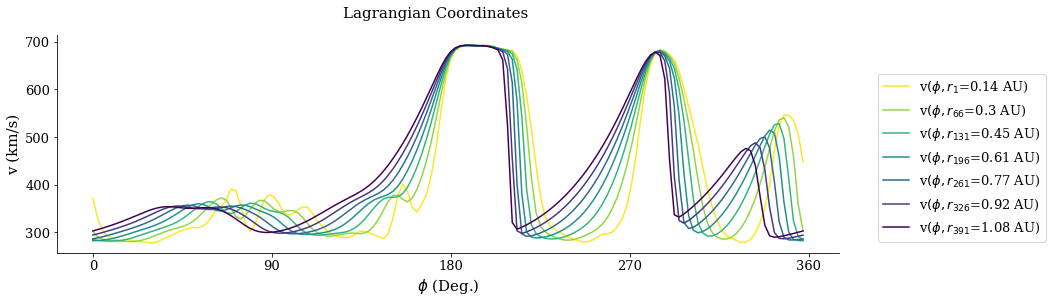

In [28]:
plot_heat_data(HUX_V_shifted.T, title="Lagrangian Coordinates", save_fig=True, file_name="figs/shifted_dynamics_analystic.png")

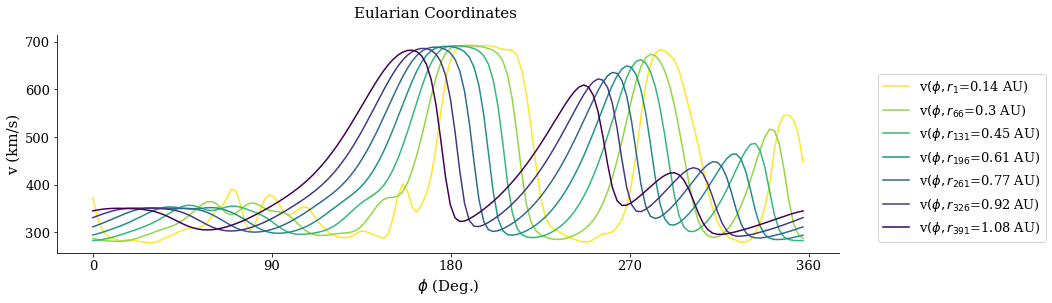

In [29]:
plot_heat_data(HUX_V.T, title="Eularian Coordinates", save_fig=True, file_name="figs/original_coordinates.png")

Radial and Longitude mesh spacing respect CFL condition of the given initial velocity profile at the Solar equator. 

* Longitude spacing 150 points: $\phi \in [0, 360]$.

* Radial spacing 400 points: $r \in [30R_{\odot}, 215 R_{\odot}]$

In [30]:
r_new.to(u.au)

<Quantity [0.13951402, 0.14192037, 0.14432673, 0.14673308, 0.14913944,
           0.15154579, 0.15395215, 0.1563585 , 0.15876485, 0.16117121,
           0.16357756, 0.16598392, 0.16839027, 0.17079663, 0.17320298,
           0.17560934, 0.17801569, 0.18042205, 0.1828284 , 0.18523476,
           0.18764111, 0.19004747, 0.19245382, 0.19486017, 0.19726653,
           0.19967288, 0.20207924, 0.20448559, 0.20689195, 0.2092983 ,
           0.21170466, 0.21411101, 0.21651737, 0.21892372, 0.22133008,
           0.22373643, 0.22614278, 0.22854914, 0.23095549, 0.23336185,
           0.2357682 , 0.23817456, 0.24058091, 0.24298727, 0.24539362,
           0.24779998, 0.25020633, 0.25261269, 0.25501904, 0.2574254 ,
           0.25983175, 0.2622381 , 0.26464446, 0.26705081, 0.26945717,
           0.27186352, 0.27426988, 0.27667623, 0.27908259, 0.28148894,
           0.2838953 , 0.28630165, 0.28870801, 0.29111436, 0.29352071,
           0.29592707, 0.29833342, 0.30073978, 0.30314613, 0.30555249,
      

In [31]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

# Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

# Reduced Order Model

We begin by assuming that the solar wind motion is described by the fluid momentum equation in corotating frame of reference.

\begin{equation} \label{momentum-equation}
-\Omega_{\text{rot}} \frac{\partial v}{\partial \phi} + (v \cdot \nabla)v = \frac{1}{\rho} \nabla P - \frac{G M_{s}}{r^2}e_{r}
\end{equation}

Where $v$ is the solar wind velocity, $\rho$ is the proton mass density, $P$ is the thermal pressure, $G$ is the gravitational constant, $r$ is the radial distance from the Sun, and $M_{s}$ is the solar mass. Unlike the conventional momentum equation, this Eq is time-stationary, in which the derivative with respect to time $\frac{\partial v}{\partial  t}$ in the conventional momentum equation has been swapped with $-\Omega_{\text{rot}}\frac{\partial v}{\partial  \phi}$ term. By neglecting the pressure gradient and gravity terms, which are assumed to be small in the heliosphere, the fluid momentum equation reduces to a nonlinear scalar homogeneous time-stationary equation, described by 

\begin{equation} \label{model}
\frac{\partial v}{\partial \phi} -\frac{1}{\Omega_{\text{rot}}}v\frac{ \partial v}{\partial r}=0
\end{equation}

where $r$ denotes the radial distance from the Sun,  $\phi$ denotes Carrington longitude in Heliographic (rotating) coordinate system (HG), and $v$ is the solar wind velocity in the radial direction. The initial-boundary value problem, or Cauchy problem with periodic initial data, is defined by Eq above on the domain $ r \geq 30 R_\odot$, $0 \leq \phi \leq 2 \pi$, where $\Omega_{\text{rot}}$ is the angular frequency of the Sun's rotation set equal to $\frac{2 \pi}{25.38} \text{1/days}$ at the solar equator, and more generally is a function of latitude.

\begin{equation} \label{omega-rot}
\Omega_{\text{rot}} (\theta) = \frac{2\pi}{25.38} - \frac{2.77\pi}{180} \cos(\theta)^2
\end{equation}

The two-dimensional model is subject to the initial condition
\begin{equation} \label{ic}
v(\phi, r_{0}) = v_{r_{0}}(\phi)
\end{equation}

with periodic boundary conditions, such that $v(0, r) = v(2\pi, r)$, for all radial locations. The underlying Eq would be considered in the form of the well-studied inviscid Burgers' equation if the propagation was in $\phi$ direction, although we are advancing in the radial direction; For instance, given an initial condition at $30 R\odot$, what is the solar wind speed near Earth at $1\text{AU}\approx 215R_\odot$? Now that we defined the problem, we are in the position to explore mathematical methods to solve our underlying equation. 


We can rewrite the underlying Eq in hyperbolic conservation  form

\begin{equation} \label{conservative-form}
    v_{r} + [f(v)]_{\phi} = 0 
\end{equation}

where the subscripts $r$ and $\phi$ denote the partial derivatives. The physical flux function is $f(v) = -\Omega_{\text{rot}} \ln(v)$ and because $f''(v) = \frac{\Omega_{\text{rot}}}{v^2} > 0$ $\forall v$, $f$ is said to be convex. When $f''(v)$ does not change signs, discontinuous solutions appear in the form of either compression or an expansion wave. 

Then, we can leverage the "upwind" scheme to approximate the derivative with respect to $\phi$ such that

$$
[f(v)]_{\phi} \approx \frac{-\Omega_{\text{rot}}}{\Delta \phi}  [\ln(v_{i, j + 1}) - \ln(v_{i, j})]
$$

where

$$
\begin{align*}
    A &= \frac{1}{-\Omega_{\text{rot}}}{\Delta \phi}\left[\begin{array}{ccccc}
        -1 & 1 & & & \\
        0 & -1 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & & -1 & 1 \\
        1 & & & 0 & -1 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{v}_0  \in\mathbb{R}^{n}.
\end{align*}
$$


we obtain the semi-discrete system

$$
\frac{d}{dr}\mathbf{v}(\phi, r) = A\ln(\mathbf{v}(\phi, r)),
$$


# Lagrangian reduced-order models

Many reduced order modeling techniques such as the Dyanmic Mode Decompostion, Proper Orthogonal Decomposition, and Operator Inference all rely on the Singular Value Decomposition (SVD) of the snapshot dataset. For translation problems, such as the problem described above of solar wind streams traveling in the heliosphere, yields to poorly reducing singular values since the modes are being averaged over all shifted solutions. The main problem lies in the translation. Although the flow has a relatively simple structure it fails to be captured by a small amount of the spatial modes. 

The main challenges as the translational property and the nonlinearity of the governing equations. Using the method of characteristics as a reference frame can solve the translational issue yet is only valid **before** a shock is formed. 
Lu et al [2] developed a physics-aware DMD method that retains information about shock formation. 




### Lagrangian Framework (Lu et al [1])

The method of characteristics can be applied to quasi-linear partial differential equations (PDEs). The underlying PDE can be rewritten in quasi-linear form as 

\begin{equation} \label{gform}
\frac{\partial v}{\partial r} - \frac{\Omega_{rot}}{v} \frac{\partial v}{\partial \phi} = 0
\end{equation}


Then, by the method of characteristics, 
\begin{equation}
\frac{\partial v}{\partial r} = 0
\end{equation}

If 
\begin{equation} \label{vline}
\frac{\partial \phi}{\partial r} = -\frac{\Omega_{rot}}{v}
\end{equation}

Hence, given this ansatz, the underlying PDE reduces to two coupled ordinary differential equations, and the characteristics may be obtained by integrating the equation above. As a result, the velocity remains constant along each characteristic and can be verified by

\begin{equation}
    \begin{split}
        \frac{d}{d r} v(r, \phi) & = \frac{\partial}{\partial r} v(r, \phi)  + \frac{\partial}{\partial \phi} v(r, \phi) \frac{\partial \phi}{\partial r} \\ & =  \frac{\partial}{\partial r} v(r, \phi)  + \frac{\partial}{\partial \phi} v(r, \phi) \cdot (-\frac{\Omega_{rot}}{v})\\ & = 0
    \end{split}
\end{equation}

Then by integrating the Eq above with respect to $r$, the characteristic are straight lines described by 

\begin{equation} \label{characteristic-curves}
\Delta \phi = -\frac{\Omega_{rot}}{v}  (\Delta r)
\end{equation}

where the solution of the first order propagating wave has a wave speed of $-\frac{\Omega_{rot}}{v}$. This approximation is called the *ballistic* approximation. It assumes that each parcel of plasma continues at a constant speed $v$ through out the heliosphere. The ballistic approximation holds when characteristic lines do not intersect. It is usually applied to mapping solar wind streams for short radial distances. 


## **References**

[1] *Lu, Hannah & Tartakovsky, Daniel. (2020). 'Lagrangian Dynamic Mode Decomposition for Construction of Reduced-Order Models of Advection-Dominated Phenomena'. Journal of Computational Physics.*

[2] *Lu, Hannah & Tartakovsky, Daniel. (2021). Dynamic Mode Decomposition for Construction of Reduced-Order Models of Hyperbolic Problems with Shocks. Journal of Machine Learning for Modeling and Computing.*

[3] *Sesterhenn, Jörn & Shahirpour, Amir. (2016). A Lagrangian Dynamic Mode Decomposition.*



In [32]:
# add an acceleration boost to the initial condition. 
# set up hyper-parameters for acceleration. 
r0=30 
alpha=0.15
rh=50 

# acceleration boost. 
v_acc = alpha * (initial_condition * (1 - np.exp(-r0 / rh)))
initial_condition += v_acc 

In [33]:
# Construct the state matrix A.
diags = np.array([-1,1]) #* (omega_rot/dp[0])
A = sparse.diags(diags, [0, 1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
fv = lambda t,x: A_mat @ np.log(x)

print(f"shape of A:\t{A.shape}")
#print(f"shape of x0:\t{initial_condition}")

shape of A:	(150, 150)


In [34]:
A_mat = A.toarray()

In [35]:
A_mat[-1, 0] = 1

In [36]:
A_mat = A_mat*(omega_rot/dp)

In [37]:
# Compute snapshots by solving the full-order model with SciPy.
V = solve_ivp(fv, [r_new[0].value,r_new[-1].value], initial_condition, 
              t_eval=r_new.value, method="BDF").y
print(f"shape of V:\t{V.shape}")

shape of V:	(150, 400)


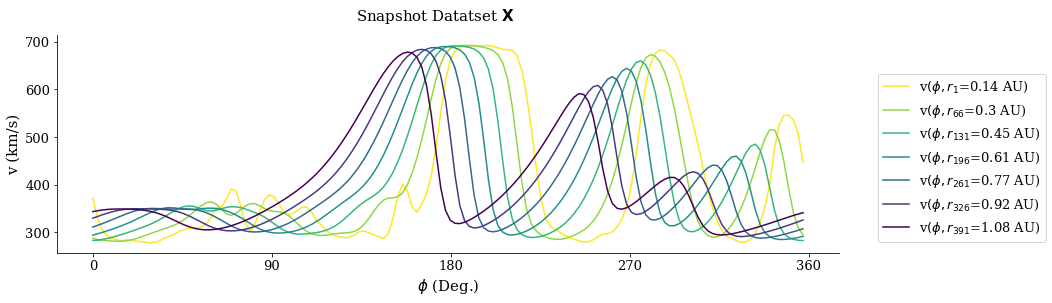

In [38]:
plot_heat_data(V, "Snapshot Datatset $\mathbf{X}$", variable="v", save_fig=True, file_name="figs/original_dataset.png")

# Breaking point


A valid question would be to ask when does the ballistic approximation fail? Can we formalize when do the characteristic lines first intersect? By doing so, we can find the exact location $(\tilde \phi, \tilde r)$, where beyond this point the ballistic approximation is no longer valid. 

Let the characteristics that first intersect emanate from $\phi_{1}$ and $\phi_{2} = \phi_{1} + \delta \phi$ such that $\phi_{1} < \phi_{2}$ and $\phi_{1}, \phi_{2} \in [0, 2\pi]$. By simple algebra, we can show that the characteristics first intersect at

\begin{equation} \label{r-break}
    \tilde r = \text{min}_{\phi_{1}, \delta \phi_{1} \in [0, 2\pi]} \{r_{0}+ (\frac{\delta \phi}{\Omega_{rot}})\frac{v(\phi_{1}, r_{0}) \cdot v(\phi_{1} + \delta \phi, r_{0})}{v(\phi_{1}, r_{0}) - v(\phi_{1} + \delta \phi, r_{0})}\} 
\end{equation}



In [39]:
r_min_intersection = np.inf
phi_meet_intersection = 0

phi0 = 0 
phi1 = 0 

num_intersection = 0 
phi_meet_vec = []
r_meet_vec = []

for ii in range(len(p_new)):     
    for jj in range(ii, len(p_new) -1):
        if ii != jj:
            deltap= (p_new[ii] - p_new[jj])
            num = initial_condition[ii] * initial_condition[jj]
            den = initial_condition[ii] - initial_condition[jj]
            
            res =  (r_new[0].value- (deltap/omega_rot)*(num/den))* u.km
             
            if  r[0] <  res < r[-1]:        
                num_intersection += 1
                
                phi_meet = p_new[ii] - omega_rot*(res.value - r[0].value)/(initial_condition[ii])
                
                phi_meet_vec.append(phi_meet)
                r_meet_vec.append(res.to(u.solRad).value)
                
                if res.value < r_min_intersection:
                    
                    r_min_intersection = res.value
                    phi_meet_intersection = phi_meet
                    phi0 = p_new[ii]
                    phi1 = p_new[jj]

In [40]:
print("minimum intersection = ", (r_min_intersection*u.km).to(u.solRad))
print("phi0 = ", phi0*(180/np.pi))
print("phi0 + delta", phi1*(180/np.pi))
print("number of intersecting characteristics in r domain", num_intersection)

minimum intersection =  80.74011041990438 solRad
phi0 =  222.94253483173463
phi0 + delta 225.33976638906512
number of intersecting characteristics in r domain 393


In [41]:

(r_min_intersection*u.km).to(u.AU)

<Quantity 0.37547924 AU>

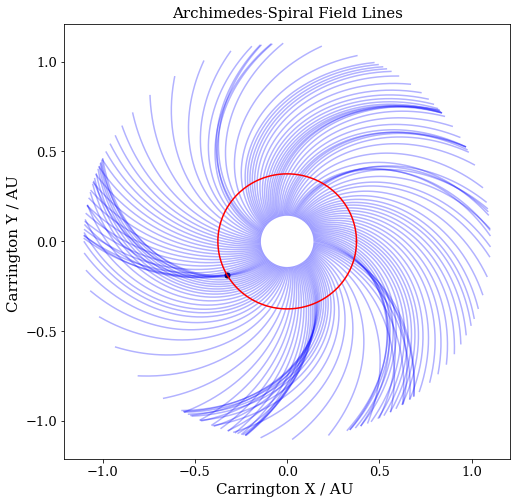

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,8), sharex=True)

jj = 0
for ii in p_new:
    phi_shift_vec = (ii - omega_rot*(dr.value)/(initial_condition[jj])*np.arange(r[1:].shape[0]))

    
    x = np.cos(phi_shift_vec)* (r[1:].to(u.AU))
    y = np.sin(phi_shift_vec)* (r[1:].to(u.AU))
    
    
    ax.plot(x, y, c="b", alpha=0.3)
    jj+=1

r_meet= (r_min_intersection*u.km).to(u.AU)
x_meet = np.cos(phi_meet_intersection)*r_meet
y_meet = np.sin(phi_meet_intersection)*r_meet
    
ax.scatter(x_meet, y_meet, s=25, c="k")

r_vec = np.ones(129)*r_meet
ax.plot(np.cos(np.append(p, 0))*r_vec,  np.sin(np.append(p, 0))*r_vec, c="r")

_ = ax.set_xlabel("Carrington X / AU ", fontsize=15)
_ = ax.set_ylabel("Carrington Y / AU ", fontsize=15)
_ = ax.set_title("Archimedes-Spiral Field Lines",  fontsize=15)

In [43]:
def compute_phi_shift_forward(p, r, v, omega=(2 * np.pi) / (25.38 * 86400), method=None):
    # initialize phi shift matrix. 
    phi_shift_mat = np.zeros((len(r), len(p)))
    
    # phi at index 0 is original phi grid 
    phi_shift_mat[0, :] = np.zeros(len(p))
    
    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r. 
    for ii in range(len(r)-1):
        if method == "ballistic":
            phi_shift = -(omega/v[:, 0])*dr
        else:
            phi_shift = -(omega/v[:, ii])*dr
        phi_shift_mat[ii+1, :] = phi_shift_mat[ii, :] + phi_shift
        
    return phi_shift_mat

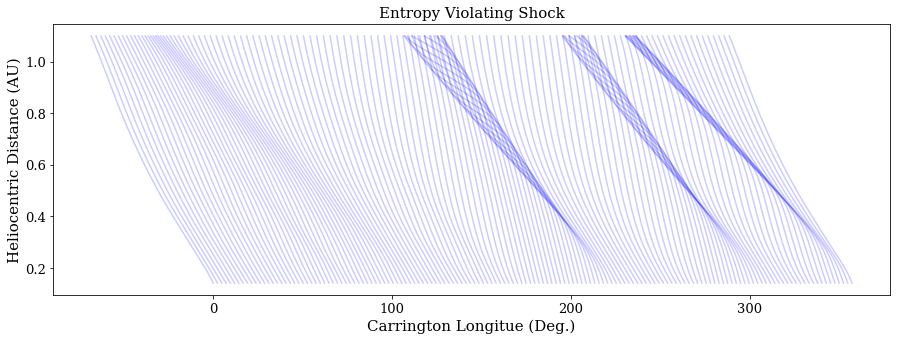

In [44]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5), sharex=True)

for kk, ii in enumerate(p_new):
    ax.plot((ii - omega_rot*(r_new[1].value -r_new[0].value)/(V[kk, 1:])*np.arange(r_new[1:].shape[0]))*(180/np.pi)
               , r_new[1:].to(u.AU), c="b", alpha=0.2)
    
_ = ax.set_xlabel("Carrington Longitue (Deg.)", fontsize=15)
_ = ax.set_ylabel("Heliocentric Distance (AU)", fontsize=15)
_ = ax.set_title("Entropy Violating Shock", fontsize=15)

# How does the longitude shift change between radial distances?

In [45]:
phi_shift = compute_phi_shift_forward(p_new, r_new.value, V)

# Lagrangian Coordinates

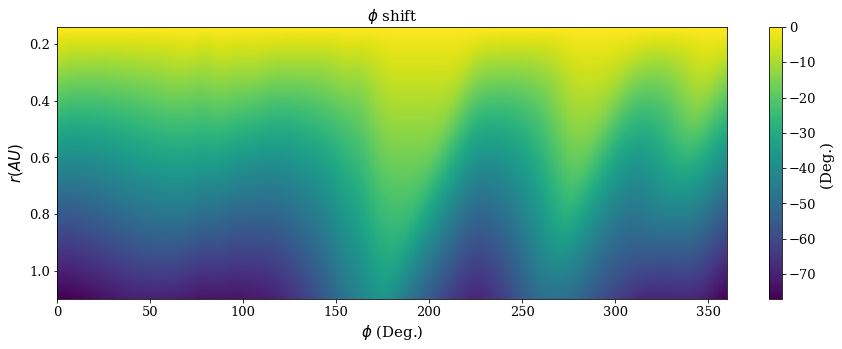

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
pos = ax.imshow((180/np.pi)*phi_shift, extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], aspect="auto")
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('(Deg.) ', rotation=90, fontsize=15)
_ = ax.set_xlabel(r"$\phi$ (Deg.)", fontsize=15)
_ = ax.set_ylabel(r"$r (AU)$", fontsize=15)
_ = ax.set_title("$\phi$ shift", fontsize=15)

In [47]:
V_new = np.zeros(V.shape)
V_new[:, 0] = V[:, 0]
avg_shift_vec = []
for jj in range(1, len(r_new)):
    avg_shift = np.mean(phi_shift[jj, :])
    avg_shift_vec.append(avg_shift)
    f_interp = interp1d(p_new, V[:, jj], fill_value="extrapolate")
    x_new = (p_new + avg_shift) % (2*np.pi)
    V_new[:, jj] = f_interp(x_new)

In [48]:
diff_avg_shift = avg_shift_vec[1:]- np.array(avg_shift_vec[:-1])

In [49]:
np.mean(diff_avg_shift)

-0.002748347503190371

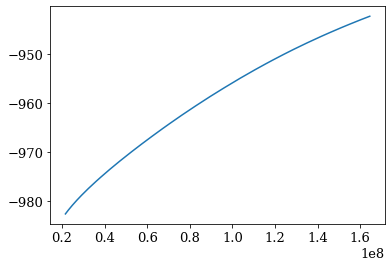

In [50]:
plt.plot(r_new[2:].value, diff_avg_shift/(omega_rot))

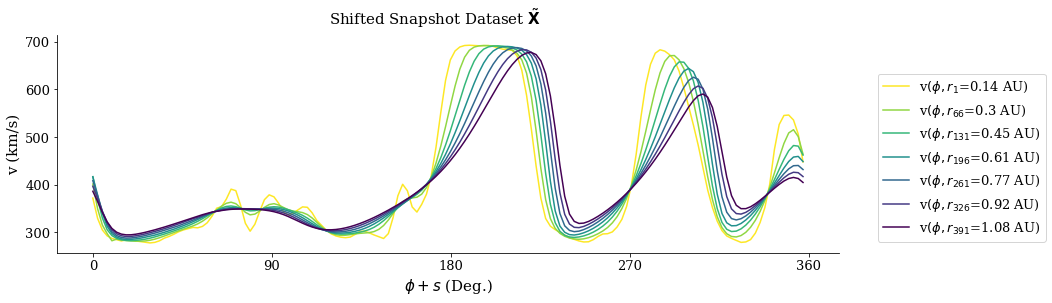

In [51]:
plot_heat_data(V_new, "Shifted Snapshot Dataset " + r"$\mathbf{\tilde{X}}$", variable="v", xlabel="$\phi + s$ (Deg.)", 
              save_fig=True, file_name="figs/shifted_dataset.png")

# Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [52]:
# set up the first l indexes used for training. 
l = int(0.8*(len(r_new)))

In [53]:
X= V_new

In [54]:
X_train = X[:, :l]
X_test = X[:, l:-1]

In [55]:
r_train = r_new[:l]
r_test = r_new[l:-1]

In [56]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r_new[0].to(u.AU)) + " to " + str(r_new[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r_new[l].to(u.AU)) + " to " + str(r_new[-1].to(u.AU)))

X train shape (150, 320)
Radial distance train: 0.13951401782886472 AU to 0.9095475030786826 AU

X test shape (150, 79)
Radial distance test: 0.9095475030786826 AU to 1.0996495197497314 AU


## Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package
Since the FOM has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A \ln (\mathbf{x}(t)),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 

We have several tasks to consider:
1. Choosing the reduced-model dimension $r$,
2. Constructing a low-dimensional subspace,
3. Computing the right-hand side data matrix $\dot{X}$,
4. Constructing the ROM via Operator Inference,
5. Simulating the ROM, and
6. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

#  Regularized OpInf Algorithm Pseudocode [1]
 
[1] Shane A. McQuarrie, Cheng Huang, Karen E. Willcox. "*Data-driven reduced-order models via regularized operator inference for a single-injector combustion process*"


### Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [57]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(V[:, :l])

In [58]:
# Calculate the cumulative energy.
thresh = .999
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 12
r (Eularian coordinates)= 10


In [59]:
# Visualize cumulative energy and threshold value(s).
#fig, ax = plt.subplots(figsize=(15, 4))
# plot singluar values cumulative energy
#ax.plot(np.arange(1, 36), np.log10(svdvals[:35]/np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
#ax.plot(np.arange(1, 36), np.log10(svdvals_prev[:35]/np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")

# plot vertical and horizontal lines based on threshhold value
#ax.hlines(-4, 0, 35, color="black", linewidth=.5, alpha=.5)

#plt.legend()
#_ = ax.set_xlim(0, 35)
#_ = ax.set_xlabel(r"Singular value index", fontsize=15)
#_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{i=0}^{k} \sigma_{i}})$", fontsize=15)
#_ = ax.set_title("Basis Dimensions", fontsize=15)

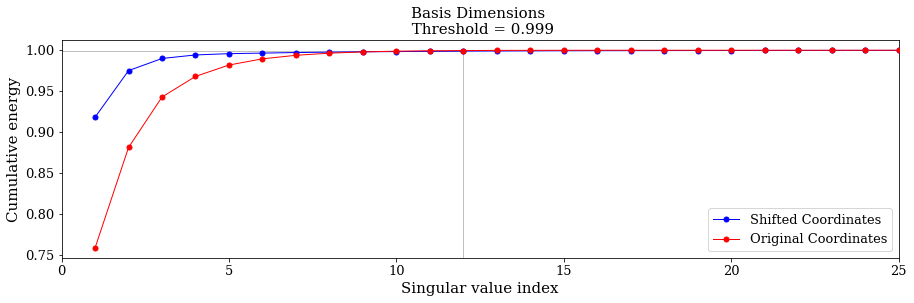

In [60]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
ax.hlines(thresh, 0, rank, color="black", linewidth=.5, alpha=.5)
ax.vlines(rank, 0, thresh, color="black", linewidth=.5, alpha=.5)
# set up axis. 

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, 25)
_ = ax.set_xlabel(r"Singular value index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative energy", fontsize=15)
_ = ax.set_title("Basis Dimensions \n Threshold = " + str(thresh), fontsize=15)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [61]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (150, 12)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

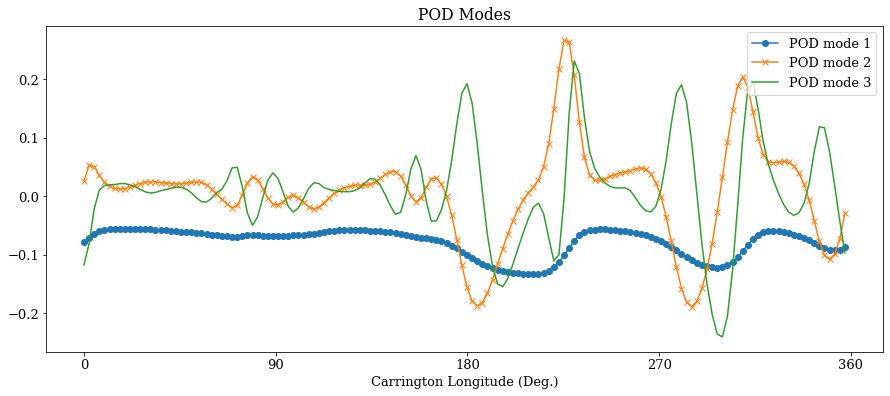

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot((180/np.pi) * p_new, Vr[:len(p_new),0], "-o", label=f"POD mode {1}")
ax.plot((180/np.pi) * p_new, Vr[:len(p_new),1], "-x", label=f"POD mode {2}")
ax.plot((180/np.pi) * p_new, Vr[:len(p_new),2], "-", label=f"POD mode {3}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),3], "--", label=f"POD mode {4}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),4], "-", label=f"POD mode {5}")


    
ax.set_xlabel("Carrington Longitude (Deg.)")
ax.set_title("POD Modes")
ax.set_xticks([0, 90, 180, 270, 360])
plt.legend(loc="upper right")
plt.show()

In [63]:
roi.pre.projection_error(X_train, Vr)

0.00034592137238015455

### Calculating the right-hand side Data Matrix

Operator Inference constructs the ROM by solving a least-squares problem that corresponds to the form of the model.
In this case, the original model has the form $\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t)$.
The snapshot matrix $X$ contains data for $\mathbf{x}(t)$, but we also need data for $\frac{d}{dt}\mathbf{x}(t)$.
In this simple example, we can directly compute the _snapshot time derivative matrix_ $\dot{X}\in\mathbb{R}^{n\times k}$ that corresponds to the snapshots by setting $\dot{X} = A X$.

\If the matrix $A$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [64]:
X_ = Vr.T @ X_train                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r_new[1]-r_new[0]).value, order = 6) # Estimate the projected time derivatives.

In [65]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{A}\hat{X} - \dot{\hat{X}}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [66]:
model.fit(Vr, X_train, Xdot_, P=1e2)

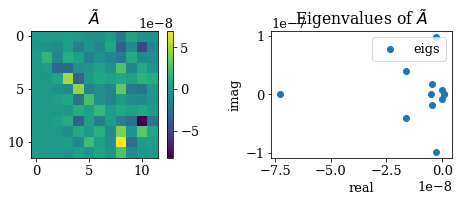

In [67]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [68]:
X_ROM = model.predict(X[:, 0], r_new.value, method="BDF")
X_ROM.shape

(150, 400)

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

In [69]:
phi_shift_rom = compute_phi_shift_forward(p_new, r_new.value, X_ROM)

In [70]:
def convert_from_x_to_v(X_ROM):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    phi_shift_rom = compute_phi_shift_forward(p_new, r_new.value, X_ROM)
    for jj in range(1, len(r_new)):
        avg_shift = np.mean(phi_shift_rom[jj, :])
        f_interp = interp1d(p_new, X_ROM[:, jj], fill_value="extrapolate")
        x_new = (p_new- avg_shift) % (2*np.pi)
        V_ROM[:, jj] = f_interp(x_new)
    return V_ROM

In [71]:
V_ROM = convert_from_x_to_v(X_ROM)

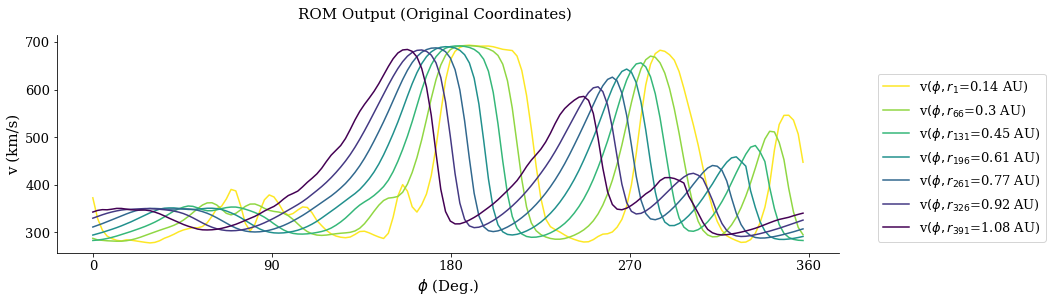

In [72]:
plot_heat_data(V_ROM, "ROM Output (Original Coordinates)", variable="v")

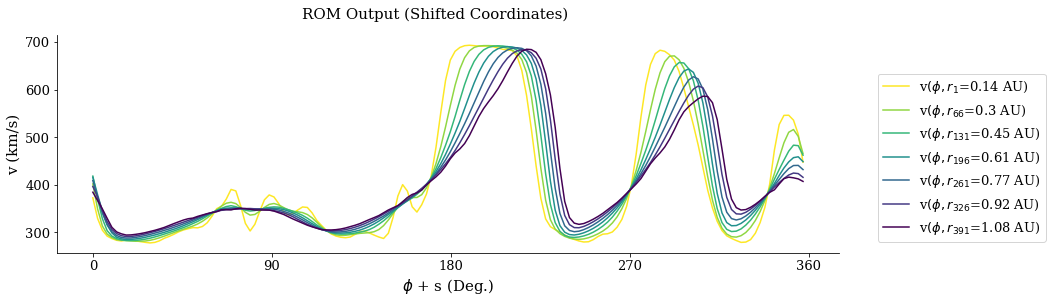

In [73]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel=r"$\phi$ + s (Deg.)")


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

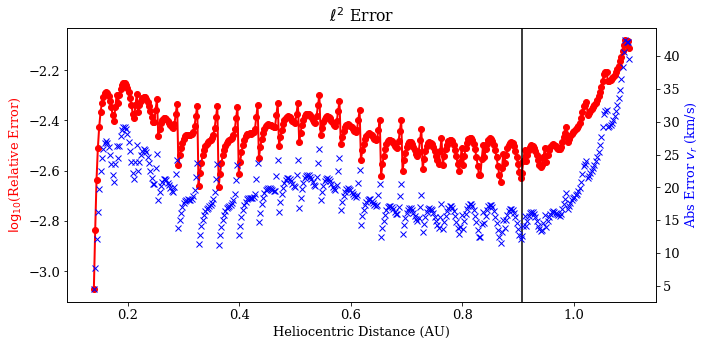

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

In [75]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 0.387183%


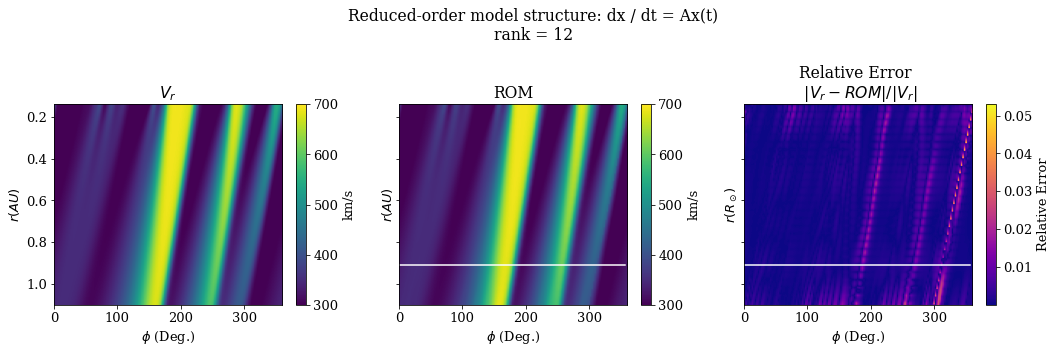

In [76]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                    r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_ylabel(r"$r (AU)$")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_ylabel(r"$r (R_\odot)$")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p_new)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

In [78]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.002133564118116654


# Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$

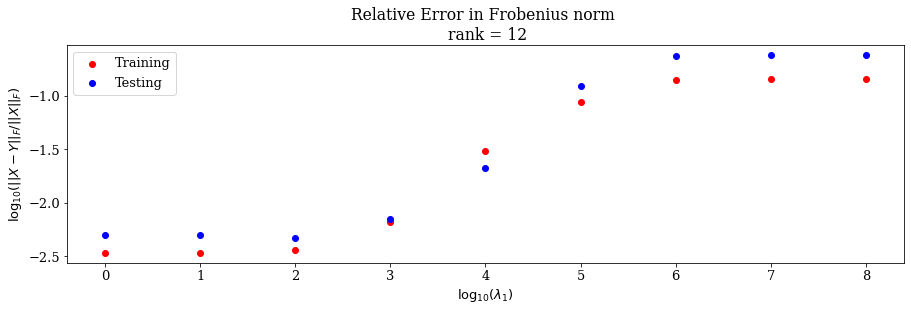

In [79]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm \n rank = " + str(rank))
_ = plt.legend()

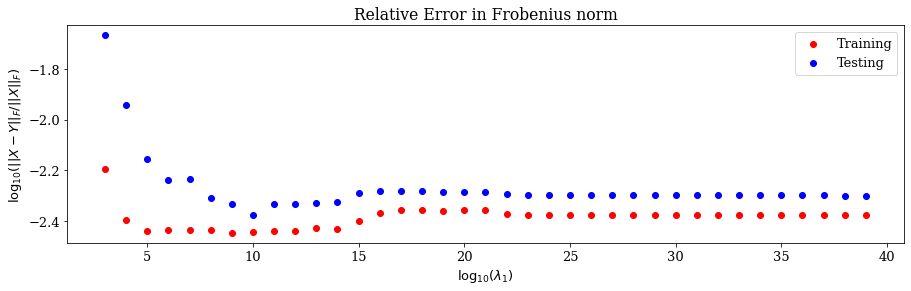

In [80]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(3, 40):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e2)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

# Quadratic ROM

In [81]:
# Calculate the cumulative energy.
thresh = .999

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 12


In [82]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=1e5)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [83]:
V_ROM = convert_from_x_to_v(X_ROM)

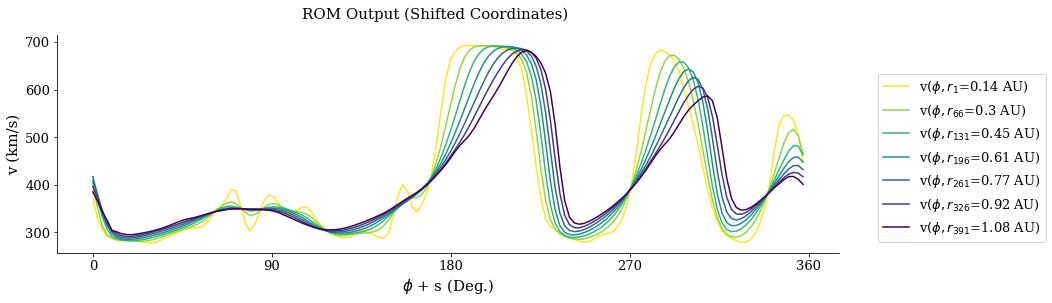

In [84]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

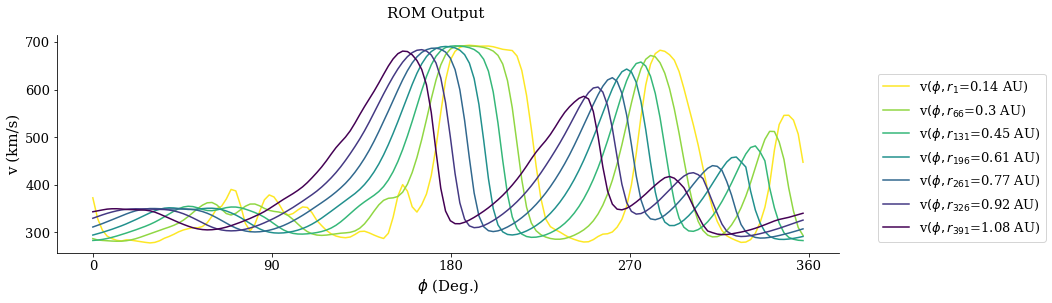

In [85]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

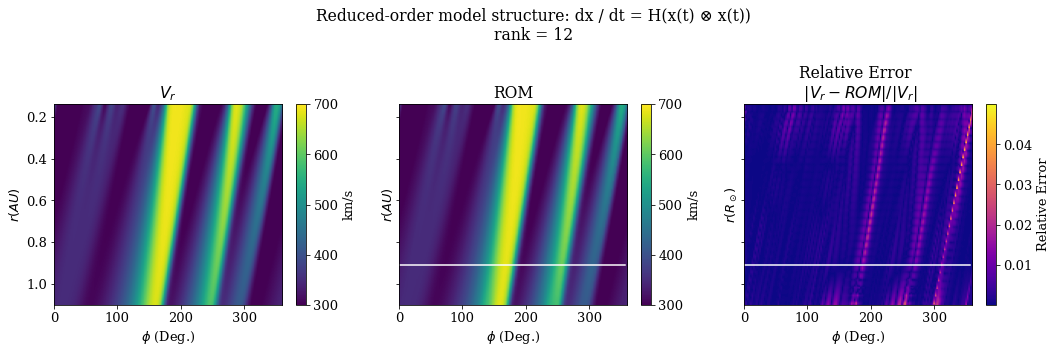

In [91]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r_new[-1].to(u.AU).value, 
                                    r_new[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_ylabel(r"$r (AU)$")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r_new[-1].to(u.AU).value, r_new[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_ylabel(r"$r (R_\odot)$")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p_new*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p_new)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

In [92]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.0022351689245947866


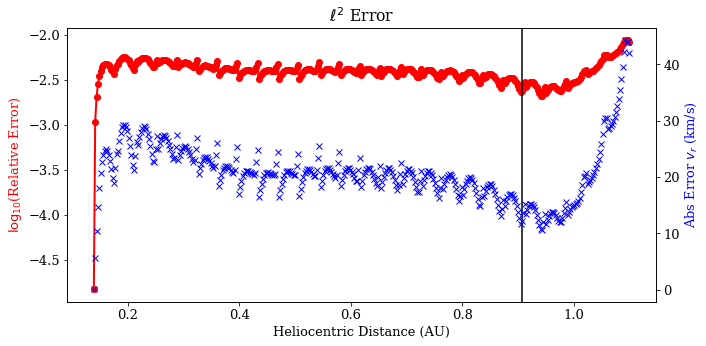

In [93]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2err, rel_l2err = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r_new.to(u.AU).value, abs_l2err, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


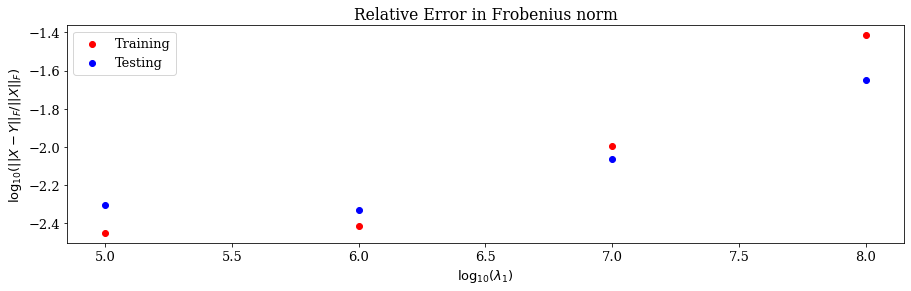

In [94]:
fig, ax = plt.subplots(figsize=(15, 4))

for coeff in [1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(np.log10(coeff), np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:185: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


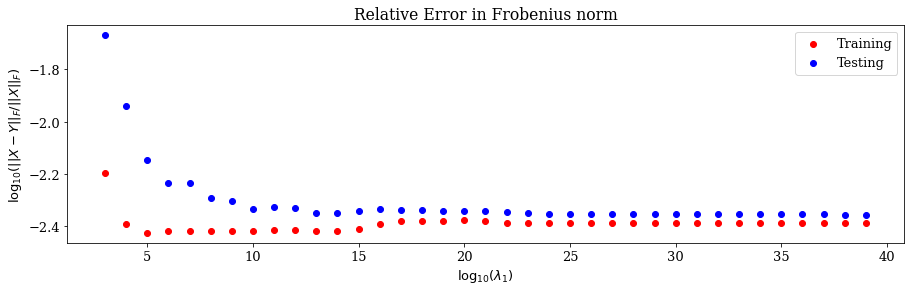

In [95]:
fig, ax = plt.subplots(figsize=(15, 4))

for r_val in np.arange(3, 40):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e6)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]), c="r")
        ax.scatter(r_val, np.log10(roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]), c="b") 
ax.scatter(0, None, c="r", label="Training")
ax.scatter(0, None, c="b", label="Testing")
_ = ax.set_xlabel("$\log_{10}(\lambda_{1})$")
_ = ax.set_ylabel("$\log_{10}(||X - Y||_{F} / ||X||_{F})$")
_ = ax.set_title("Relative Error in Frobenius norm")
_ = plt.legend()

# Lagrangian DMD for shock preserving

![](figs/Lag_dmd_alg_2.png)

### Step 1 : decompose the initial velocity profile into regions of monotonicity. 

In [96]:
diff_v =  np.roll(V[:, 0], 1) - V[:, 0]
asign = np.sign(diff_v)
signchange = ((np.roll(asign, 1) - asign) != 0)

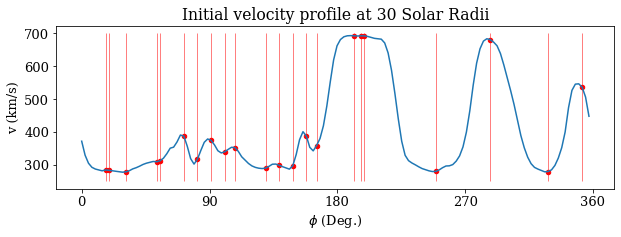

In [97]:
fig, ax = plt.subplots(figsize=(10, 3))
_ = ax.plot((180/np.pi)*p_new, V[:, 0])
_ = ax.scatter((180/np.pi)*p_new[signchange], V[:, 0][signchange], s=20, c="red")
for jj, ii in enumerate(signchange):
    if ii==1:
        _ = ax.vlines((180/np.pi)*p_new[jj], 250, 700, colors="red", linewidth=0.5)
_ = ax.set_xlabel("$\phi$ (Deg.)")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_ylabel("v (km/s)" )
_ = ax.set_title("Initial velocity profile at 30 Solar Radii")

* **Increasing regions = Shock.**
* **Decreasing regions = rarefraction.**

# Sensitivity to Training Data

* **Test 1**: 120 training snapshots. 

* **Test 2**: 150 training snapshots. 

* **Test 3**: 180 training snapshots.

In [98]:
# initialize the training length. 
l1, l2, l3 = 150, 200, 250


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [99]:
r_train1 = r_new[:l1]
r_test1 = r_new[l1:-1]

r_train2 = r_new[:l2]
r_test2 = r_new[l2:-1]

r_train3 = r_new[:l3]
r_test3 = r_new[l3:-1]

In [100]:
# l1 = compute the results for quadradic with 3 modes.
rank=3
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1E6)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1E6)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1E6)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r_new.value, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

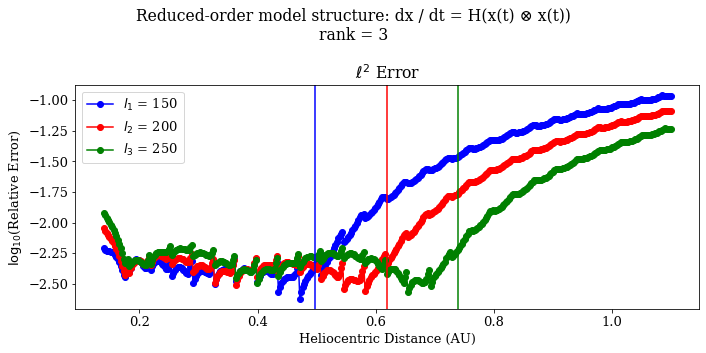

In [101]:
fig, ax = plt.subplots(figsize=(10, 5))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err1), "-o", c="b", label="$l_{1}$ = " + str(l1))

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err2), "-o", c="r", label="$l_{2}$ = " + str(l2))

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3)
_ = ax.plot(r_new.to(u.AU).value, np.log10(rel_l2err3), "-o", c="g", label="$l_{3}$ = " + str(l3))

_ = ax.axvline(r_train1[-1].to(u.AU).value, c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, c="g")
_ = ax.set_title(r"$\ell^2$ Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.legend()
plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()